In [1]:
% cd ~/Documents/GitHub/cs231n-adni/new_code

/Users/elissali/Documents/GitHub/cs231n-adni/new_code


In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
import data, model, interpretation, utils, vis_utils

torch.Size([32, 1])


In [4]:
train_data = np.load("train_aug.npy")
val_data = np.load("val_aug.npy")
test_data = np.load("test_aug.npy")
train_label = np.load("train_label_aug.npy")
val_label = np.load("val_label_aug.npy")
test_label = np.load("test_label_aug.npy")

train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))
val_data = np.reshape(val_data, (512, 1, 64, 64, 64))
test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

# Visualisation

In [5]:
train_data[0].shape

(1, 64, 64, 64)

In [24]:
train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))      # want channels first!
test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

In [25]:
neg_ex = torch.squeeze(torch.from_numpy(test_data[0]))
pos_ex = torch.squeeze(torch.from_numpy(test_data[500]))

print(pos_ex.shape)

torch.Size([64, 64, 64])


tensor(-1.0605, dtype=torch.float64) tensor(3.3168, dtype=torch.float64) None None


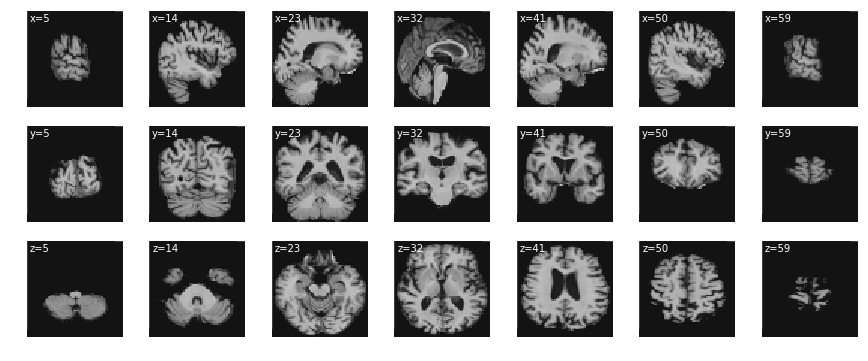

In [26]:
vis_utils.plot_slices(neg_ex)

tensor(-1.3015, dtype=torch.float64) tensor(2.7594, dtype=torch.float64) None None


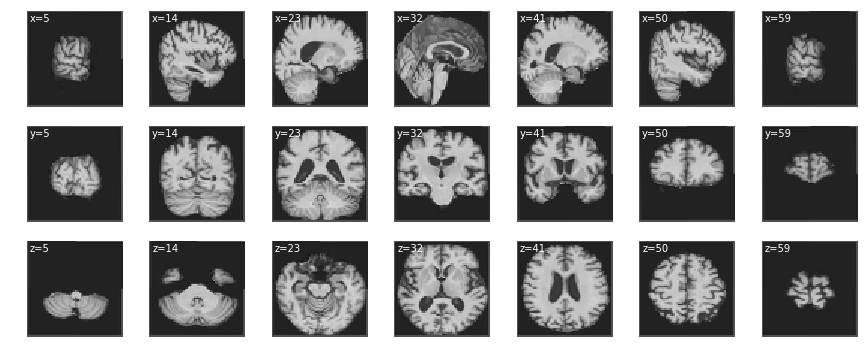

In [27]:
vis_utils.plot_slices(pos_ex)

In [28]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [29]:
# net.load_state_dict(torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model'])

In [30]:
net.load_state_dict(torch.load('../ckpt/2020_5_13_1_30/epoch004.pth.tar')['model'])

<All keys matched successfully>

In [31]:
# for item in net.state_dict():
#     print(item)

# for item in torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model']:
#     print(item)

In [32]:
net.eval();

In [33]:
train_data[2000][0].shape
train_data[0][0].shape

(64, 64, 64)

# Sensitivity Analysis

NC example:

In [35]:
relevance_map_backprop = interpretation.sensitivity_analysis(net, test_data[0], cuda=False, verbose=True)

Image was classified as 1 with probability 0.6656020283699036
one hot output:  tensor([[[0.],
         [1.]]])


tensor(-1.0605, dtype=torch.float64) tensor(3.3168, dtype=torch.float64) 1.410179e-10 0.020235077021644406


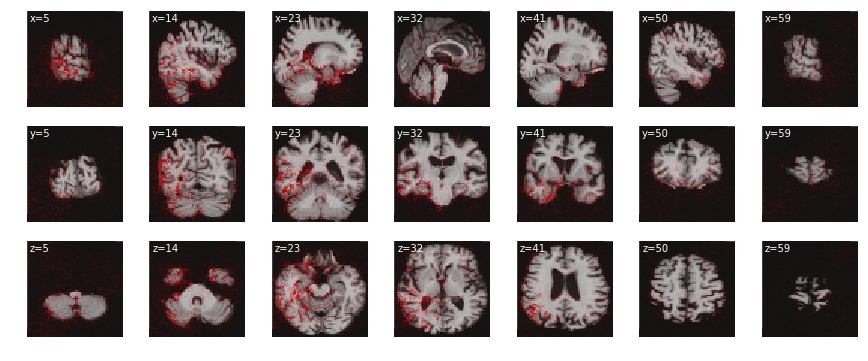

In [36]:
vis_utils.plot_slices(neg_ex, num_slices = 7, overlay=relevance_map_backprop[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

AD example:

In [37]:
relevance_map_backprop = interpretation.sensitivity_analysis(net, test_data[500], cuda=False, verbose=True)

Image was classified as 1 with probability 0.9644808769226074
one hot output:  tensor([[[0.],
         [1.]]])


-1.301479531090039 2.759426819189698 1.6260628e-09 0.0031296073663980573


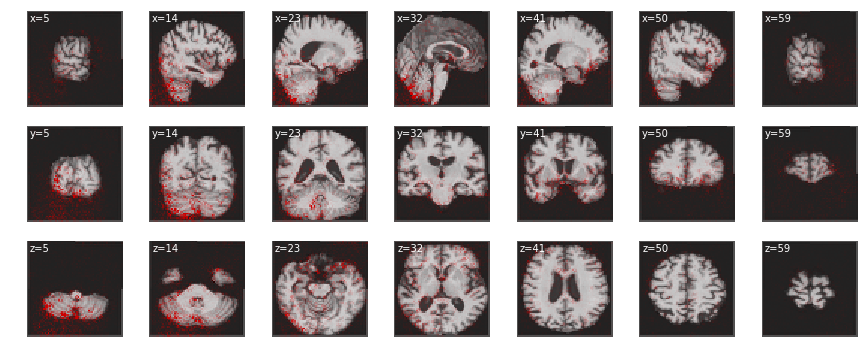

In [38]:
vis_utils.plot_slices(test_data[500][0], overlay=relevance_map_backprop[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

# Guided Backprop

NC example:

In [39]:
relevance_map_guided = interpretation.guided_backprop(net, test_data[0], cuda=False, verbose=True)

Image was classified as 1 with probability 0.6656020283699036
one hot output:  tensor([[[0.],
         [1.]]])
Removing 0 hook(s)


tensor(-1.0605, dtype=torch.float64) tensor(3.3168, dtype=torch.float64) 1.410179e-10 0.020235077021644406


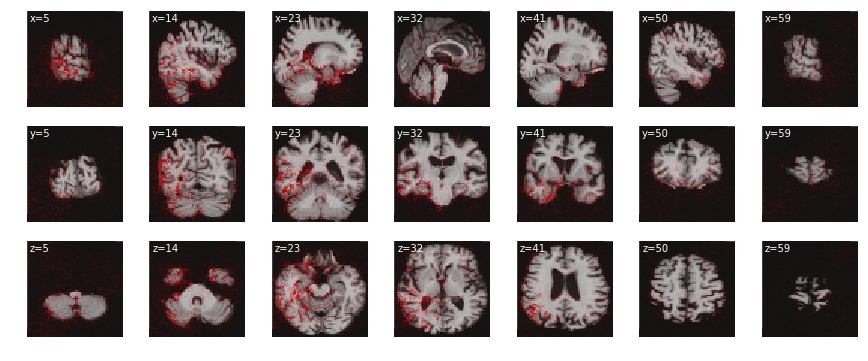

In [40]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_guided[0], 
                  overlay_vmax=np.percentile(relevance_map_guided, 99.9))

AD example:

In [43]:
relevance_map_guided = interpretation.guided_backprop(net, test_data[500], cuda=False, verbose=True)

Image was classified as 1 with probability 0.9644808769226074
one hot output:  tensor([[[0.],
         [1.]]])
Removing 0 hook(s)


tensor(-1.3015, dtype=torch.float64) tensor(2.7594, dtype=torch.float64) 1.6260628e-09 0.0031296073663980573


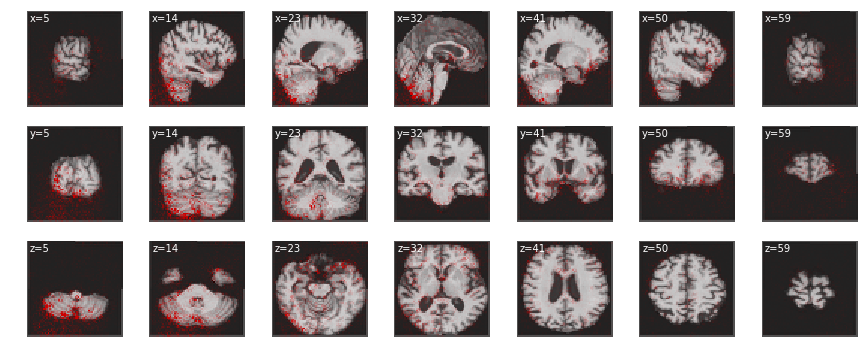

In [44]:
vis_utils.plot_slices(pos_ex, overlay=relevance_map_guided[0], 
                  overlay_vmax=np.percentile(relevance_map_guided, 99.9))

# Occlusion

NC example:

In [45]:
relevance_map_occlusion = interpretation.occlusion(net, test_data[0], size=10, stride=5, cuda=False, resize=True, verbose=True)

three_d:  True
Image was classified as 1 with probability 0.6656020283699036
xs, ys:  range(0, 64, 5) range(0, 64, 5)
depth:  64
zs:  range(0, 64, 5)


tensor(-1.0605, dtype=torch.float64) tensor(3.3168, dtype=torch.float64) 0.0 0.4336789846420288


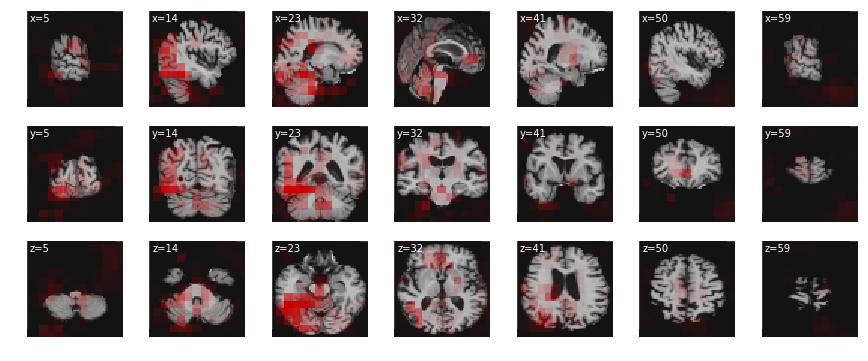

In [46]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_occlusion, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [47]:
relevance_map_occlusion = interpretation.occlusion(net, test_data[500], size=15, stride=7, cuda=False, resize=True, verbose=True)

three_d:  True
Image was classified as 1 with probability 0.9644808769226074
xs, ys:  range(0, 64, 7) range(0, 64, 7)
depth:  64
zs:  range(0, 64, 7)


tensor(-1.3015, dtype=torch.float64) tensor(2.7594, dtype=torch.float64) 0.0 0.07681554555892944


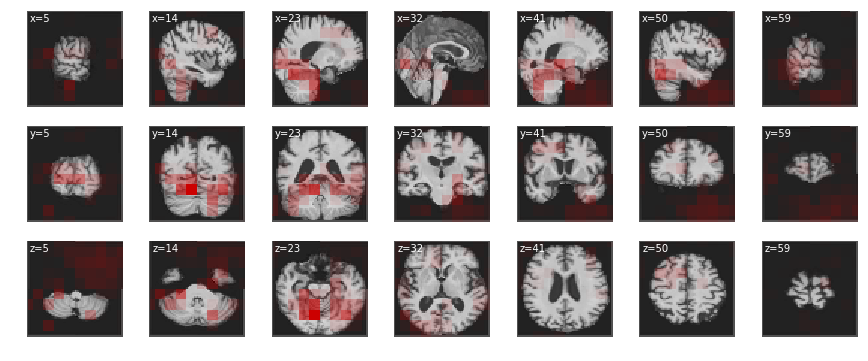

In [48]:
vis_utils.plot_slices(pos_ex, overlay=relevance_map_occlusion, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [ ]:
# Plot occlusion patch on image.
occluded_image = train_data[0][0][:, 30, :].copy()
size = 20
occluded_image[10:10+size, 20:20+size] = 0
plt.imshow(occluded_image, cmap='gray')
plt.axis('off')

# Brain Area Occlusion

In [49]:
brain_map = vis_utils.load_nifti('aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    area_mask = vis_utils.resize_image(area_mask, pos_ex.shape, interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

In [50]:
def get_relevance_per_area(relevance_map, normalize=True):
    relevances = np.zeros(len(area_masks))
    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)
    if normalize:
        relevances /= relevances.sum()  # make all areas sum to 1

    # Merge left and right areas.
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    return sorted(zip(merged_area_names, merged_relevances), key=lambda a, b: b, reverse=True)

In [52]:
relevance_map_area_occlusion = interpretation.area_occlusion(net, test_data[0], area_masks, cuda=False, verbose=True)

Image was classified as 1 with probability 0.6656020283699036
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])


tensor(-1.0605, dtype=torch.float64) tensor(3.3168, dtype=torch.float64) 0.0 0.28811353


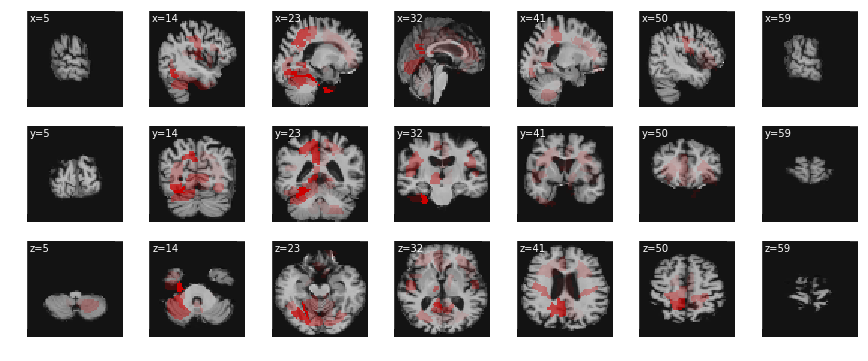

In [53]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_area_occlusion, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)

In [ ]:
relevance_map_area_occlusion = interpretation.area_occlusion(net, test_data[500], area_masks, cuda=False, verbose=True)

Image was classified as 1 with probability 0.9644808769226074
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])


In [ ]:
vis_utils.plot_slices(test_data[500][0], overlay=relevance_map_area_occlusion, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)